In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

In [145]:
df = pd.read_excel("data/Nile.xlsx", index_col=0)
df.head()
# df.Nile.copy().to_list()

,Nile
1871,1120
1872,1160
1873,963
1874,1210
1875,1160


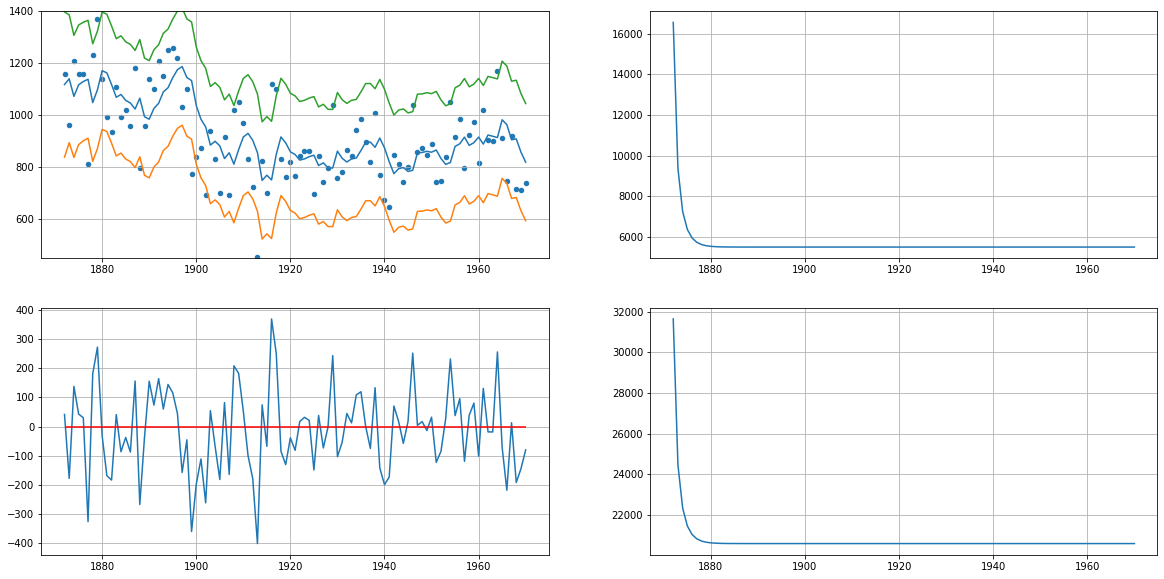

In [181]:
def Kalman_filter(series:pd.Series, P1:float, a1:float, s2_e:float, s2_n:float):
    t_crit = 1.57
    y_list = series.copy().to_list()
    r = pd.DataFrame(columns=['a', 'P', 'v', 'F', 'K', 'ci'])
    
    a = a1
    P = P1
    
    for i,y in enumerate(y_list):
        
        # compute all variables
        v = y - a
        F = P + s2_e
        K = P/F

        # store result for t=i
        r.loc[i] = [a, P, v, F, K, t_crit * F**.5]
        
        # filtered (nowcasting)
        a_f = a + K * v
        P_f = P * (1 - K)

        # predict for t+1
        a_p = a_f
        P_p = P_f + s2_n

        # store prediction t+1 for next iteration
        a = a_p
        P = P_p

    r["y"] = series.values
    r.index = series.index
    return r

df_kf = Kalman_filter(series = df.Nile, P1=1e7, a1=0, s2_e = 15099, s2_n = 1469.1)
df_kf = df_kf.iloc[1:]

fig, axs = plt.subplots(2,2, figsize=(20,10))

# upper left
ax = axs[0,0]
ax.scatter(df_kf.index, df_kf.y, s=20)
df_kf.a.plot(ax=ax)
(df_kf.a-df_kf.ci).plot(ax=ax)
(df_kf.a+df_kf.ci).plot(ax=ax)
ax.set_ylim(450, 1400)

# lower left
ax = axs[1,0]
ax.plot(df_kf.index, df_kf.v)
ax.hlines(y = 0, xmin= df_kf.index.min(), xmax=df_kf.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_kf.index, df_kf.P)


# lower right
ax = axs[1,1]
ax.plot(df_kf.index, df_kf.F)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


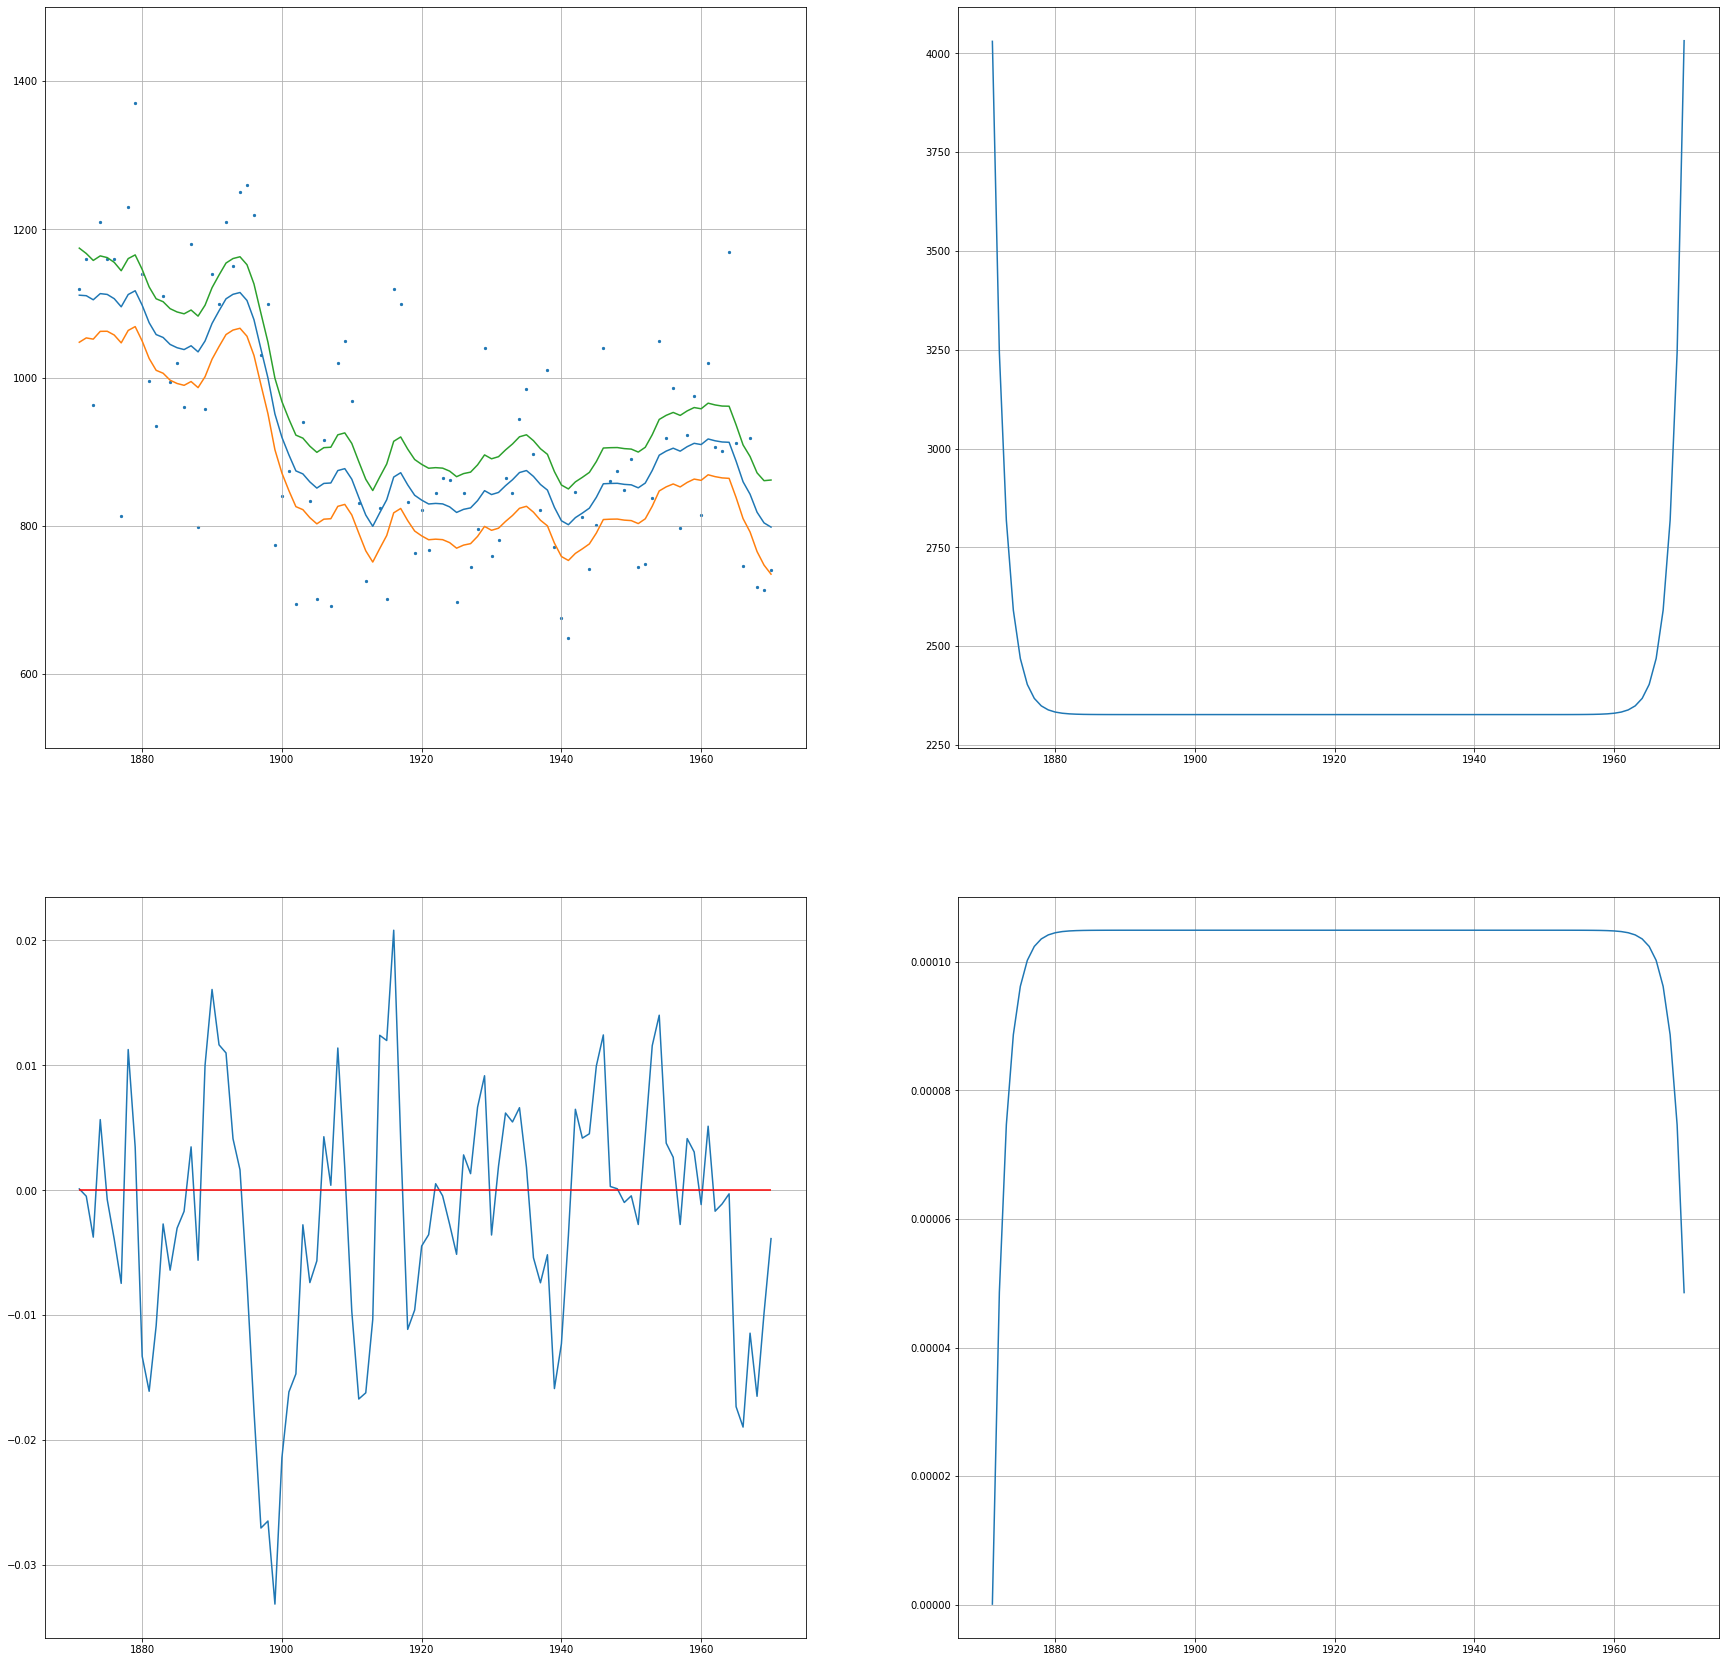

In [182]:
def Kalman_smoother(y: pd.Series, P1: float, a1: float, s2_e: float, s2_n: float, r_n: float, N_n: float):
    df_kf = Kalman_filter(y, P1, a1, s2_e, s2_n)
    ind = df_kf.index
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a', 'N', 'V', 'err'])

    r = r_n
    N = N_n
    
    for i, row in df_kf.iterrows():
        
        r = row['F']**-1 * row['v'] + (1-row['K'])*r
        a = row['a'] + row['P']*r
        N = row['F']**-1 + (1-row['K'])**2 * N
        V = row['P'] - row['P']**2 * N

        df_ks.loc[i] = [r, a, N, V, V**0.5]
        
    # store existing data
    df_ks["y"] = df_kf["y"]
    add_columns = [c for c in df_kf.columns if c not in df_ks.columns]
    df_ks[add_columns] = df_kf[add_columns]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    df_ks.index = ind
    return df_ks

df_ks = Kalman_smoother(y=df.Nile, P1=10**7, a1=0, s2_e = 15099, s2_n = 1469.1, r_n = 0, N_n = 0)

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df.index, df.Nile, s=5)
ax.plot(df_ks.index, df_ks.a)
ax.plot(df_ks.index, df_ks.a-df_ks.err)
ax.plot(df_ks.index, df_ks.a+df_ks.err)
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, df_ks.r)
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.V)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.N)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


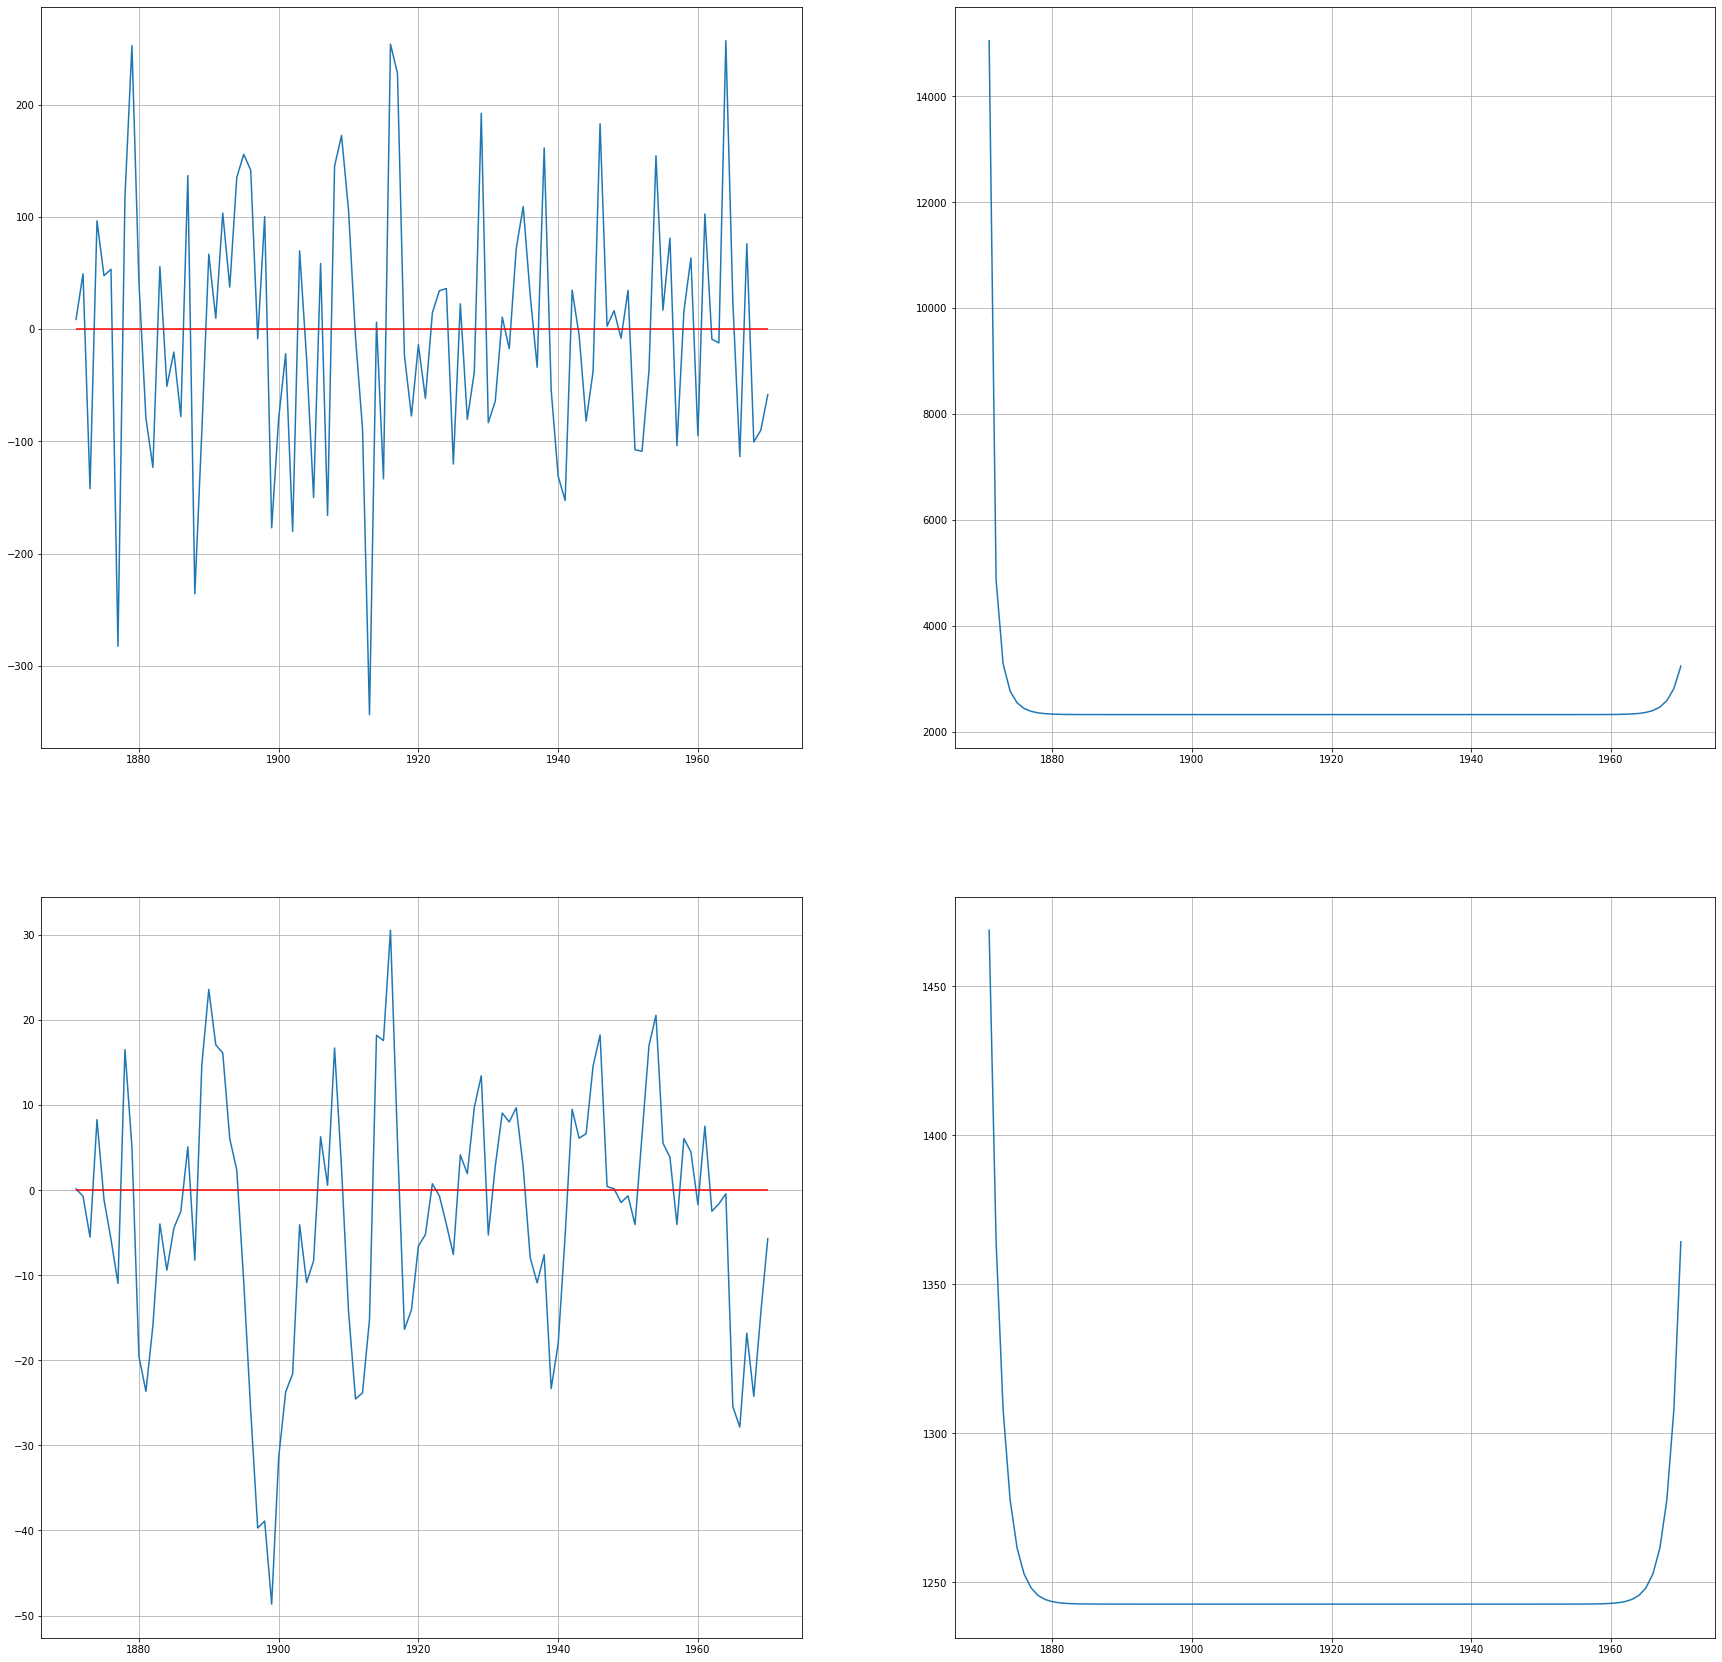

In [200]:
def dist_smoothing(y: pd.Series, P1, a1, s2_e, s2_n, r_int, N_int):
    ind = y.index
    series = y.copy().to_list()
    df_kf = Kalman_filter(y, P1,a1, s2_e, s2_n)
    df_ks = Kalman_smoother(y, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ds = pd.DataFrame(columns=['eps', 'n', 'var_eps', 'var_n'])

    for i, row in df_ks.iterrows():

        eps = row.y - row.a

        D = row.F**(-1) + row.K**2 * row.N
        var_eps = s2_e - s2_e**2 * D
        var_n = s2_n - s2_n**2 * row.N
        n = s2_n * row.r
        
        df_ds.loc[i] = [eps, n, var_eps, var_n]

    df_ds.index = df_ks.index
    df_ds["y"] = df_ks["y"]

    return df_ds

df_ds = dist_smoothing(y=df.Nile, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0)

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.plot(df_ds.index, df_ds['eps'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# lower left
ax = axs[1,0]
ax.plot(df_ds.index, df_ds['n'])
ax.hlines(y = 0, xmin= df.index.min(), xmax=df.index.max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ds.index, df_ds['var_eps'])


# lower right
ax = axs[1,1]
ax.plot(df_ds.index, df_ds['var_n'])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


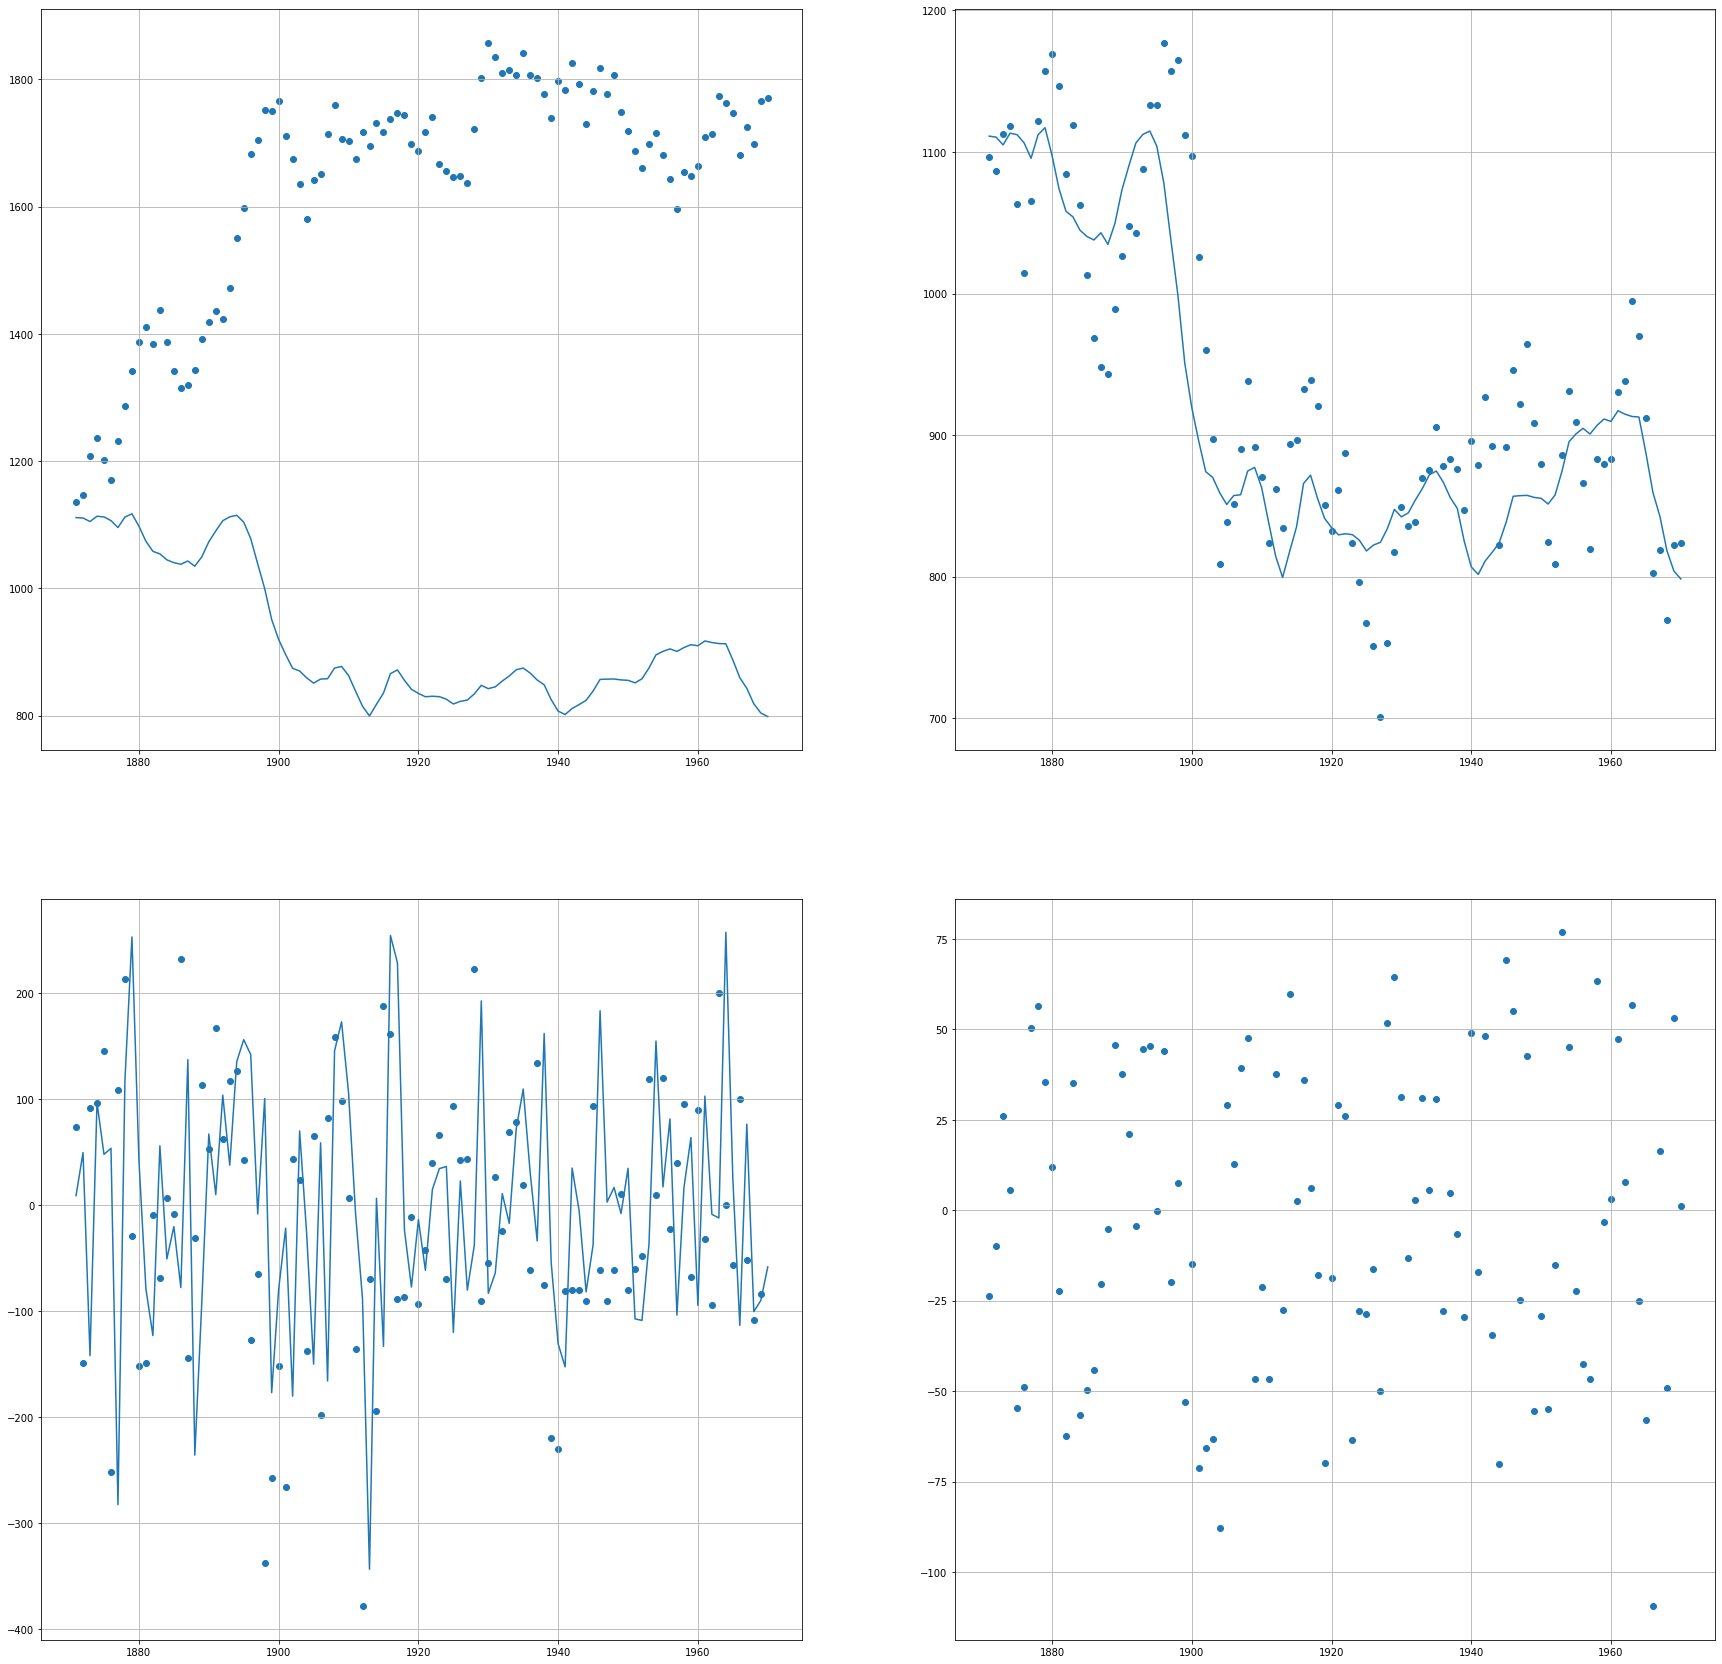

In [238]:
def llm_sim(df, P1, a1, s2_e, s2_n, r_int, N_int, a1_plus):

    df_kf = Kalman_filter(df.Nile, P1, a1, s2_e, s2_n)
    df_ks = Kalman_smoother(df.Nile, P1, a1, s2_e, s2_n, r_int, N_int)
    df_ks["eps"] = df_ks.y - df_ks.a
    df_ds = dist_smoothing(df.Nile, P1, a1, s2_e, s2_n, r_int, N_int)
    
    # draw sample
    eps_list = np.random.randn(len(df)) * np.sqrt(s2_e)
    eta_list = np.random.randn(len(df)) * np.sqrt(s2_n)
    df_sim = pd.DataFrame({
        "eps_sim": eps_list,
        "eta_sim": eta_list,
        "y_sim": a1_plus + np.cumsum(eta_list) + eps_list,
        "a_sim": a1_plus + np.cumsum(eta_list)
    })
    
    df_sim_ks = Kalman_smoother(df_sim.y_sim, P1, a1, s2_e, s2_n, r_int, N_int)

    a = a1_plus
    a_prev = a1_plus
    df_llm = pd.DataFrame(columns=['alpha_kringeltje', 'eps_kringeltje', 'eta_kringeltje'])
    for i, y in enumerate(df.Nile.to_list()):

        # draw random variables
        row_ks = df_sim_ks.loc[i]
        eps_sim_est = row_ks.y - row_ks.a
        eps_sim = eps_list[i]

        # eps_kringeltje = eps - 
        eps_kringeltje = eps_sim - eps_sim_est + df_ks.iloc[i]["eps"]
        a_kringeltje = y - eps_kringeltje
        
        eta_kringeltje = a_kringeltje - a_prev
        a_prev = a_kringeltje
        
        # store result
        df_llm.loc[i] = [a_kringeltje, eps_kringeltje, eta_kringeltje]
        
    # add true data to df
    df_llm["y"] = df.Nile.to_list()
    df_llm["eps_kringeltje"] = df_llm["eps_kringeltje"].shift(-1)
    df_llm.index = df.index
    
    # store simulation in df_llm
    df_llm["y_sim"] = df_sim["y_sim"].to_list()
    df_llm["a_sim"] = df_sim["a_sim"].to_list()
    return df_ks, df_llm

df_ks, df_llm = llm_sim(df=df, P1=1e7, a1=0, s2_e=15099, s2_n=1469.1, r_int=0, N_int=0, a1_plus=df.Nile.values[0])

fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df_llm.index, df_llm.a_sim)
ax.plot(df_ks.index, df_ks.a)

# lower left
ax = axs[1,0]
ax.plot(df_ks.index, (df_ks.y - df_ks.a))
ax.scatter(df_llm.index, df_llm.eps_kringeltje)

# upper right
ax = axs[0,1]
ax.plot(df_ks.index, df_ks.a)
ax.scatter(df_llm.index, df_llm.alpha_kringeltje)


# lower right
ax = axs[1,1]
ax.plot(df_ks.index, df_ks.a.diff().shift(-1))
ax.scatter(df_llm.index, df_llm.eta_kringeltje)

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass      
plt.show()  